# Main Functions 

Welcome to MacroDensity's tutorial Jupyter Notebook. This notebook contains a few examples of how MacroDensity's basic functions are used. 

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ase.io.cube

import macrodensity as md

## Plotting the planar and macroscopic average 
We can calculate the planar and macroscopic potential average of a material using the function `md.plotting.plot_planar_average`. This function can post-process different output files, including `CHGCAR`, `LOCPOT`, `.cube` and `gulp.out`:

### Post-processing `VASP` `CHGCAR` and `LOCPOT`

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  8.000000069794417
Average of the average =  7.72953392288895


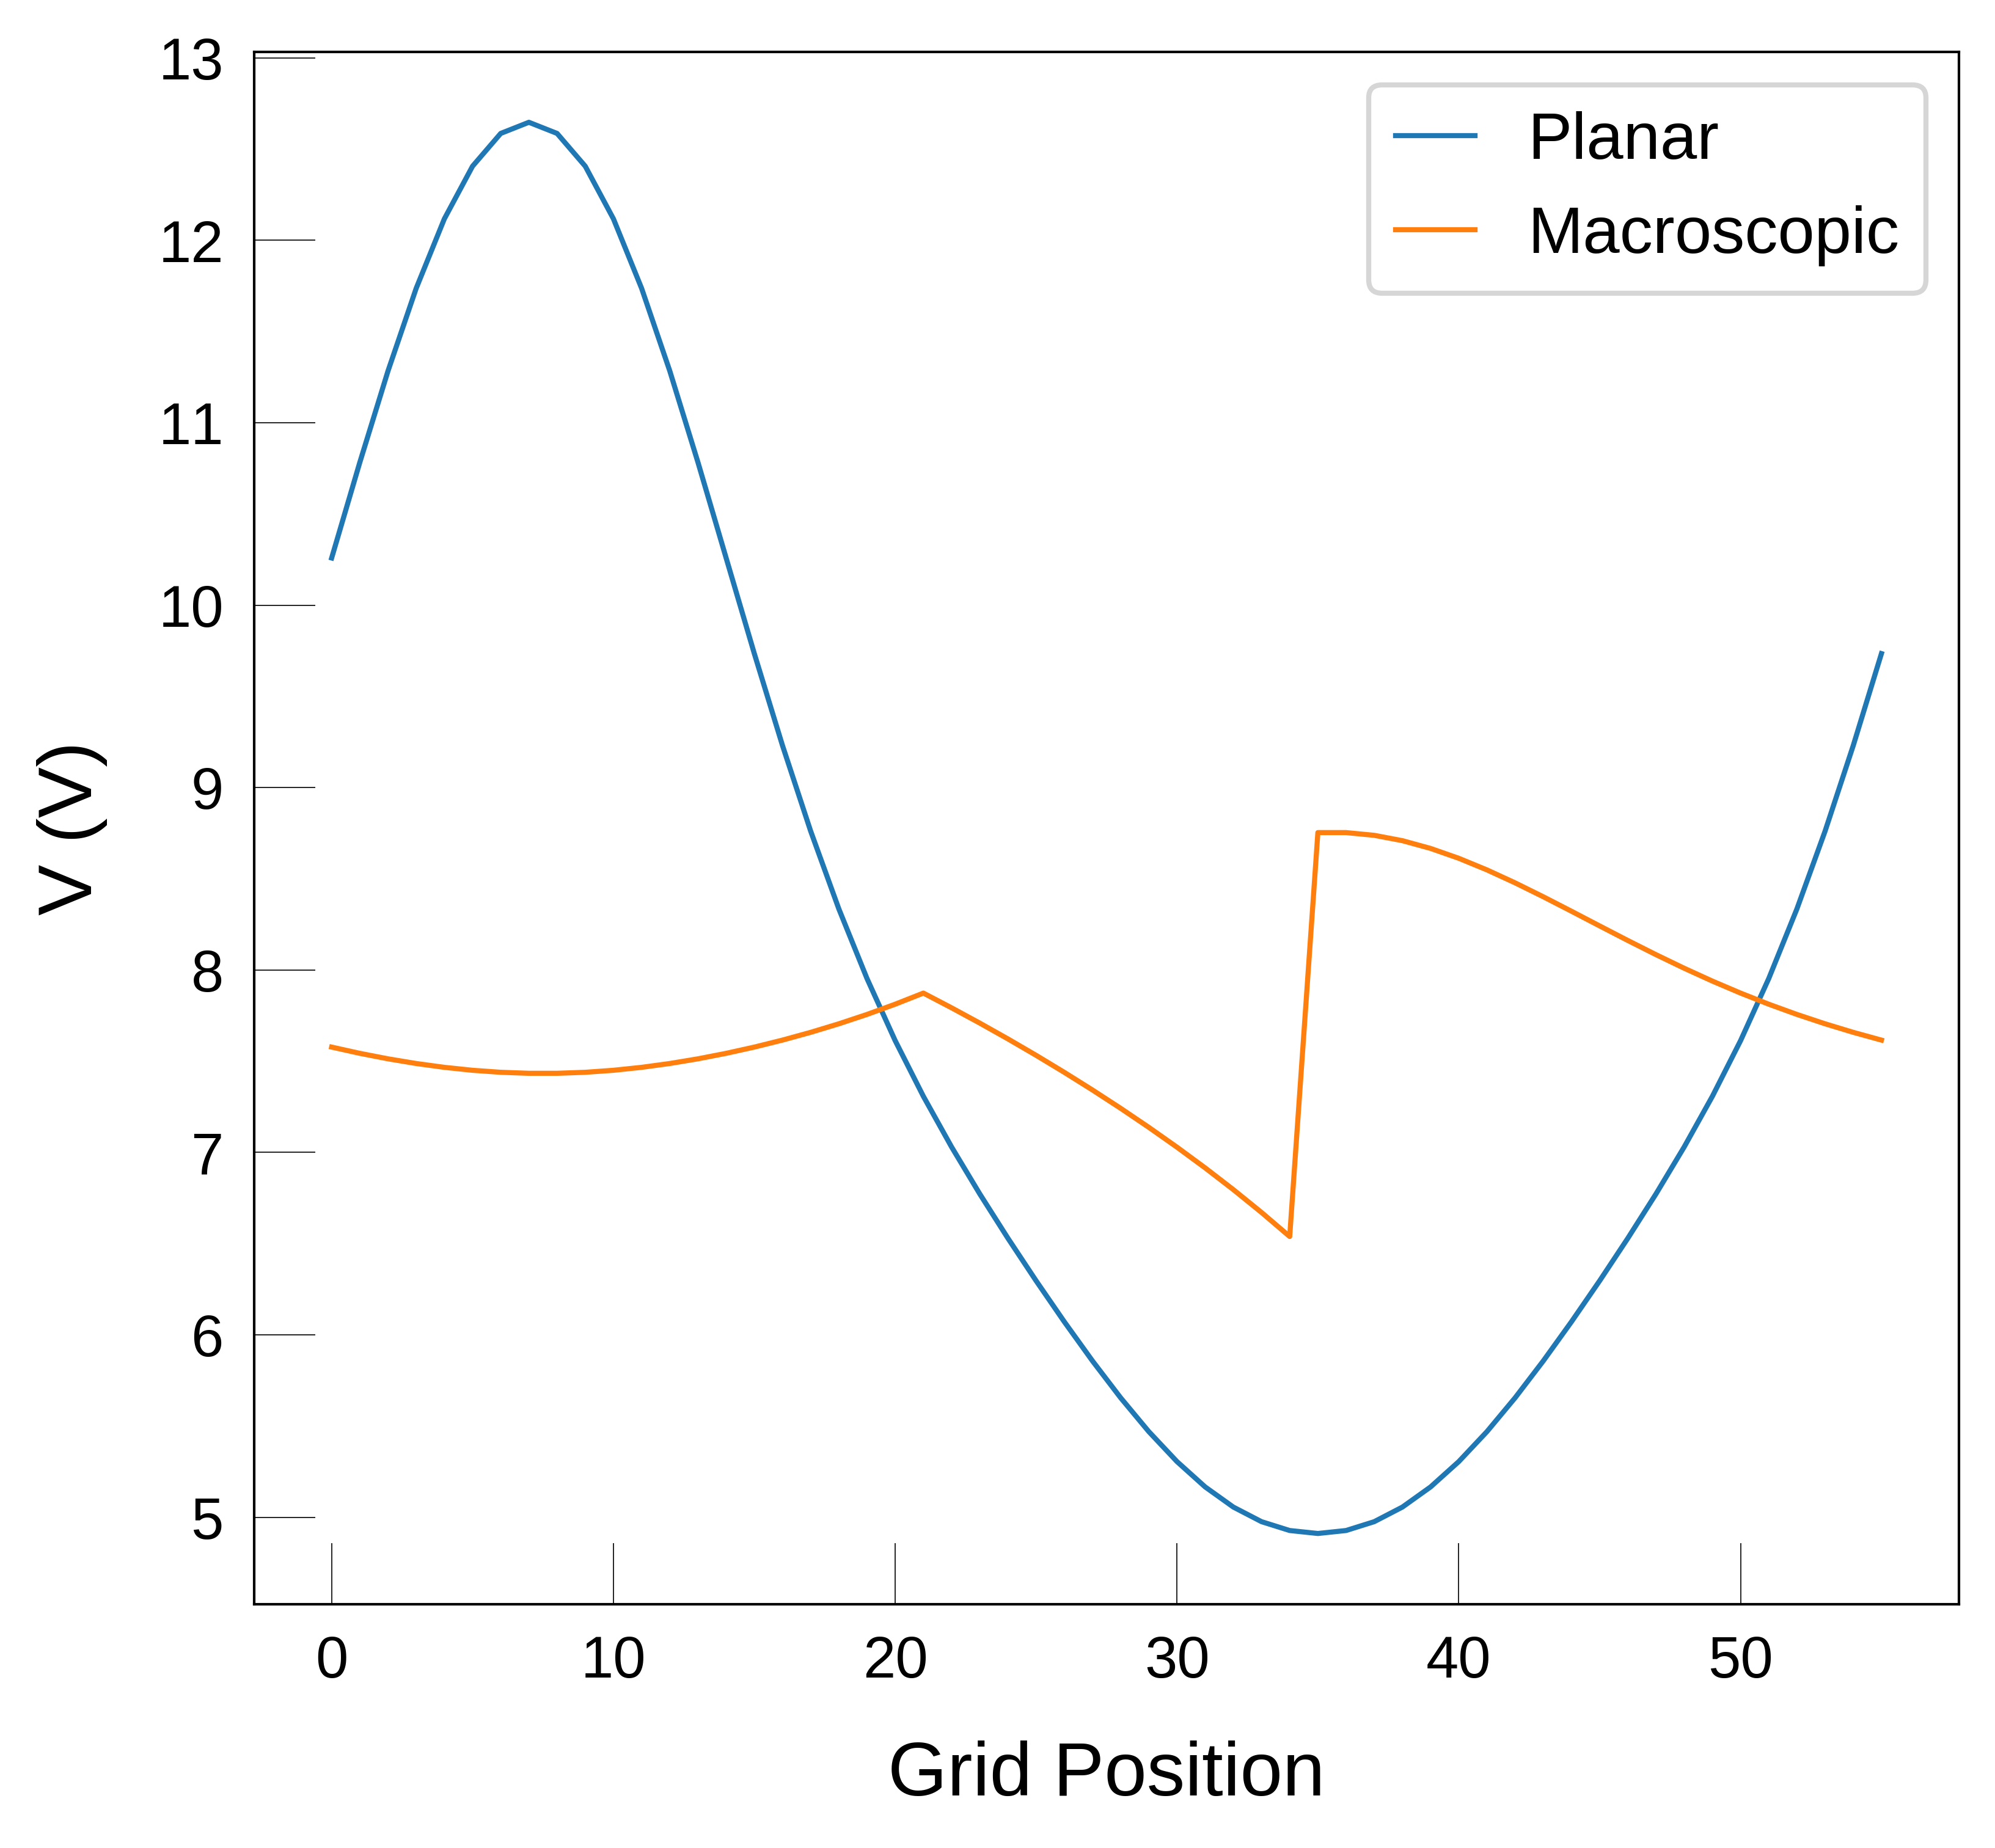

In [7]:
# Using the VASP CHGCAR file:
lattice_vector = 4.75
df, fig = md.plotting.plot_planar_average(
    input_file='CHGCAR.test',
    lattice_vector=lattice_vector,
    axis="z",
)

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Average of the average =  -0.07045532018119124


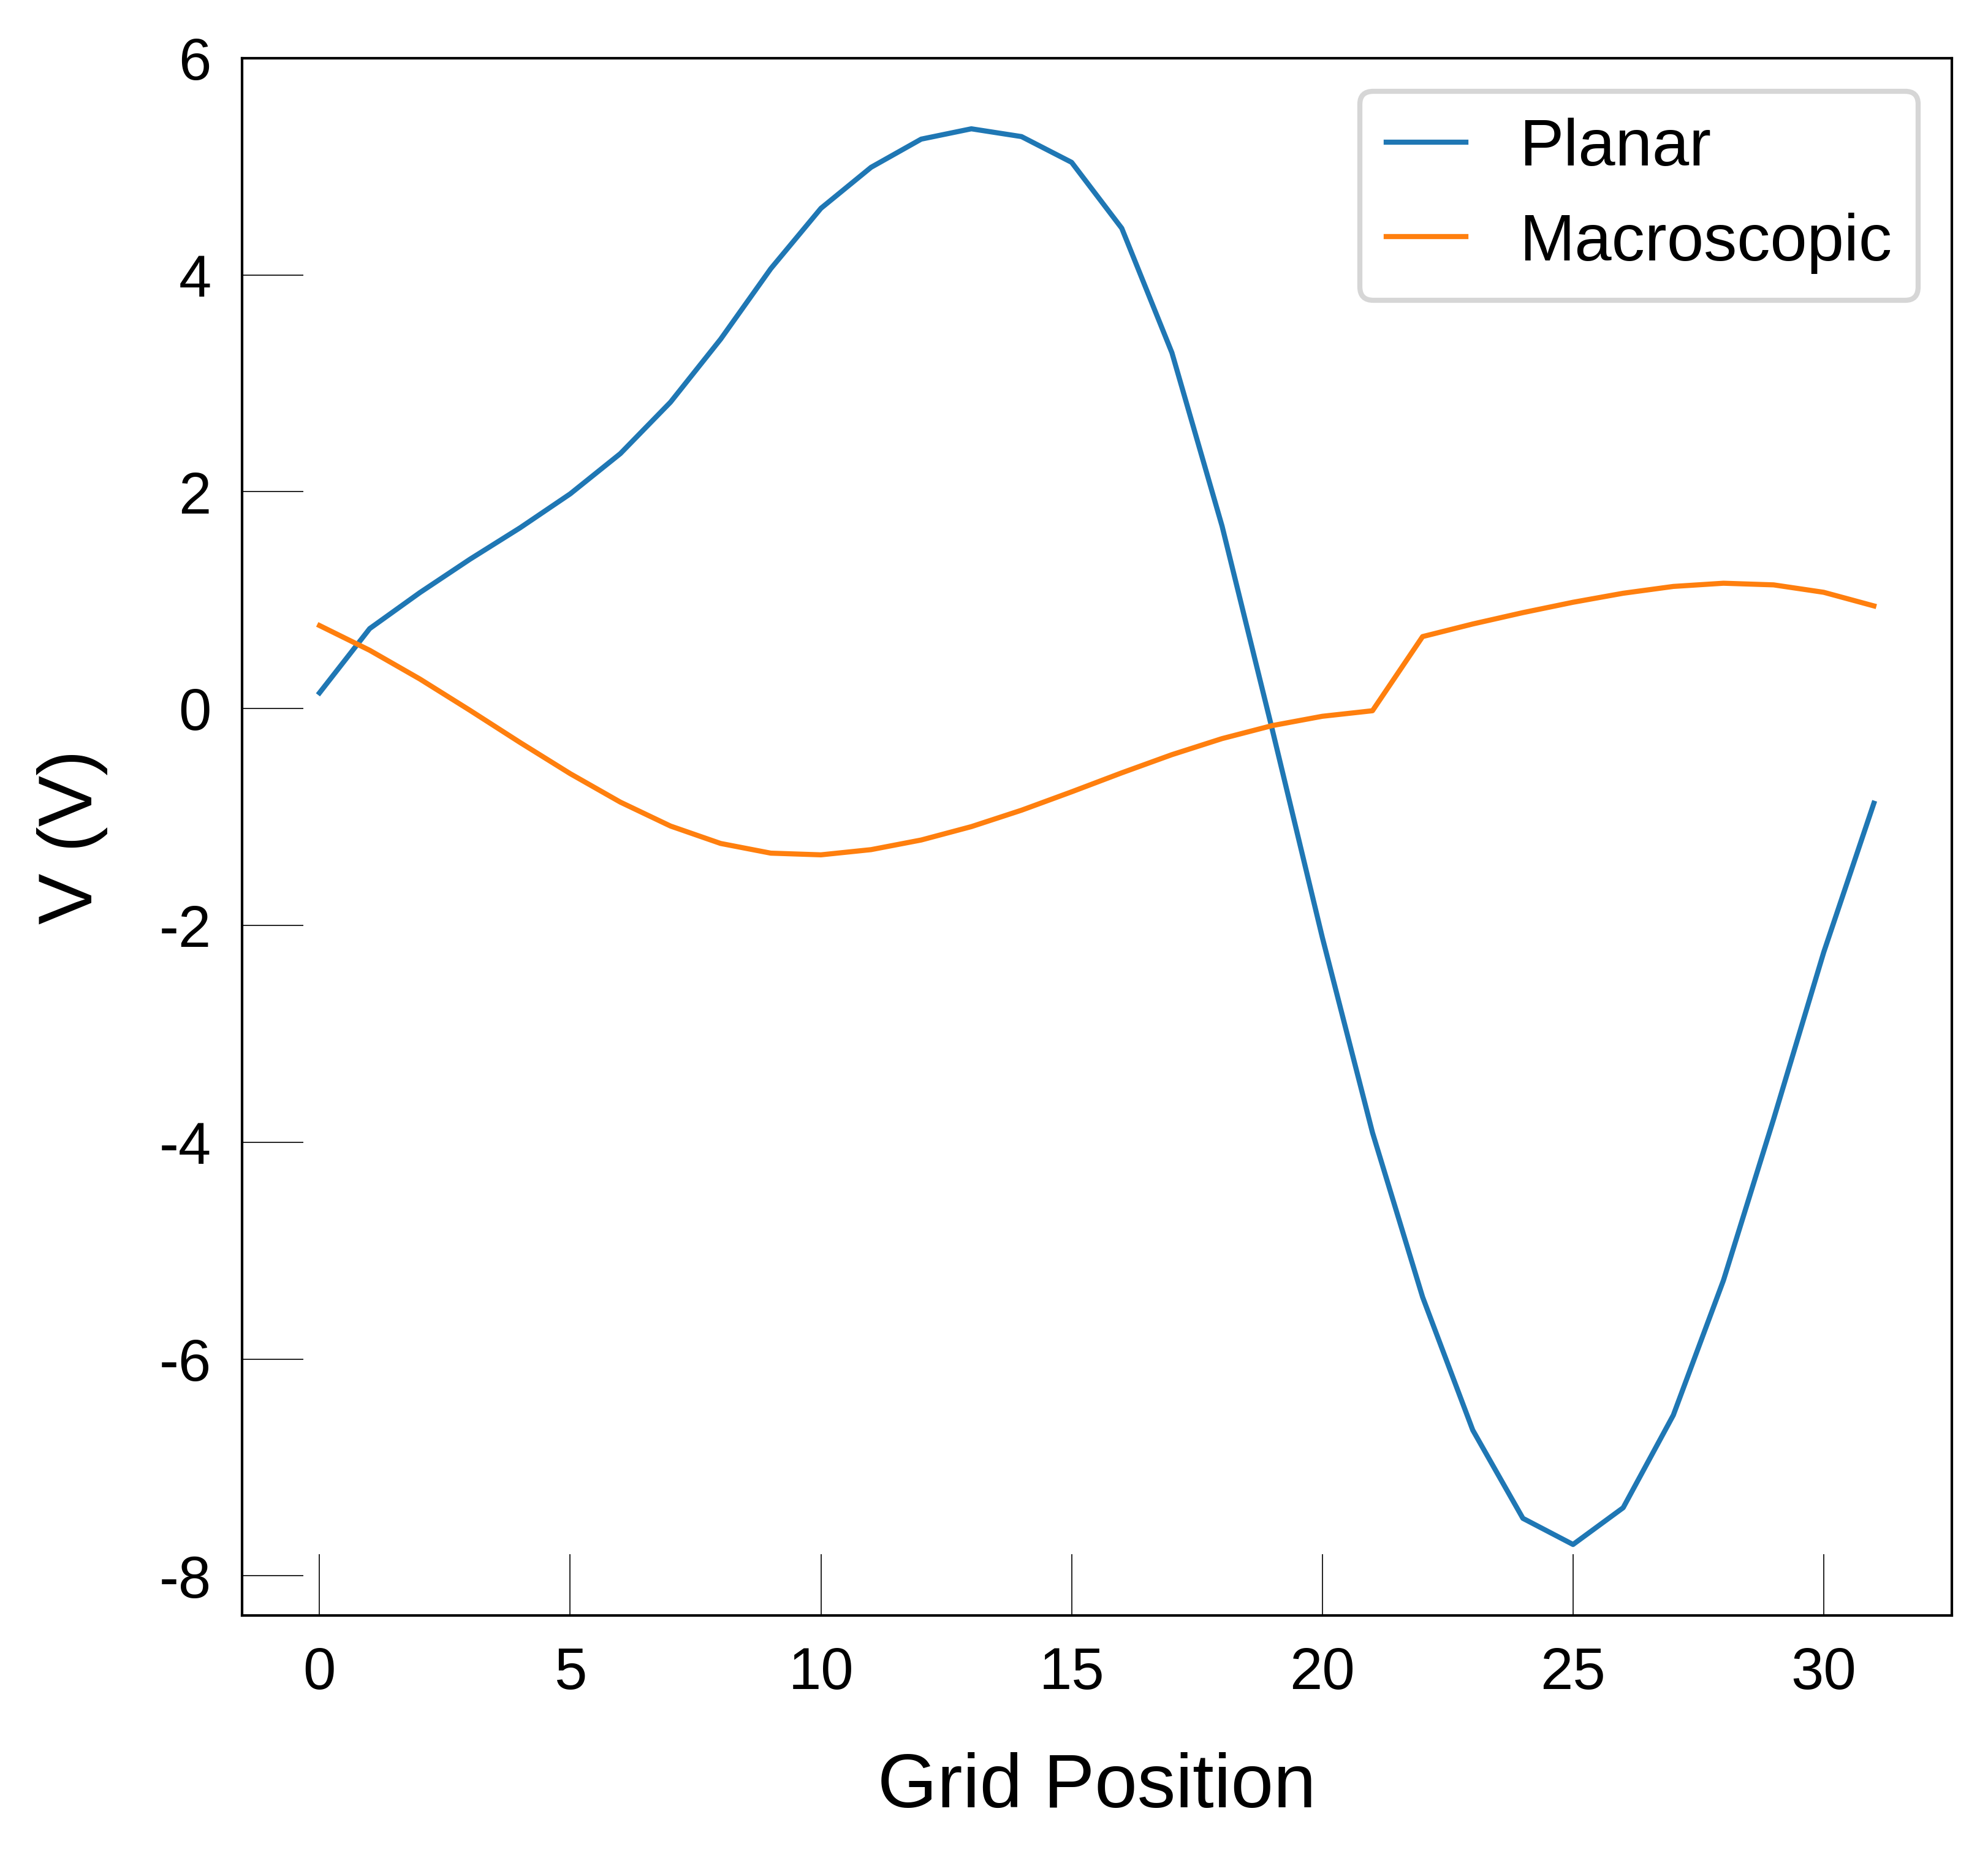

In [8]:
input_file = 'LOCPOT.test'
lattice_vector = 5.41
output_file = 'PlanarAverage.csv' 
img_file = 'PlanarAverage.png' 

df, fig = md.plot_planar_average(
    lattice_vector=lattice_vector, 
    input_file=input_file, 
    axis="z",
    output_file=output_file, # Save the data to a CSV file
    img_file=img_file # Save the image to a PNG file
)

### Post-processing a `cube` file

Average of the average =  0.004323820372140808


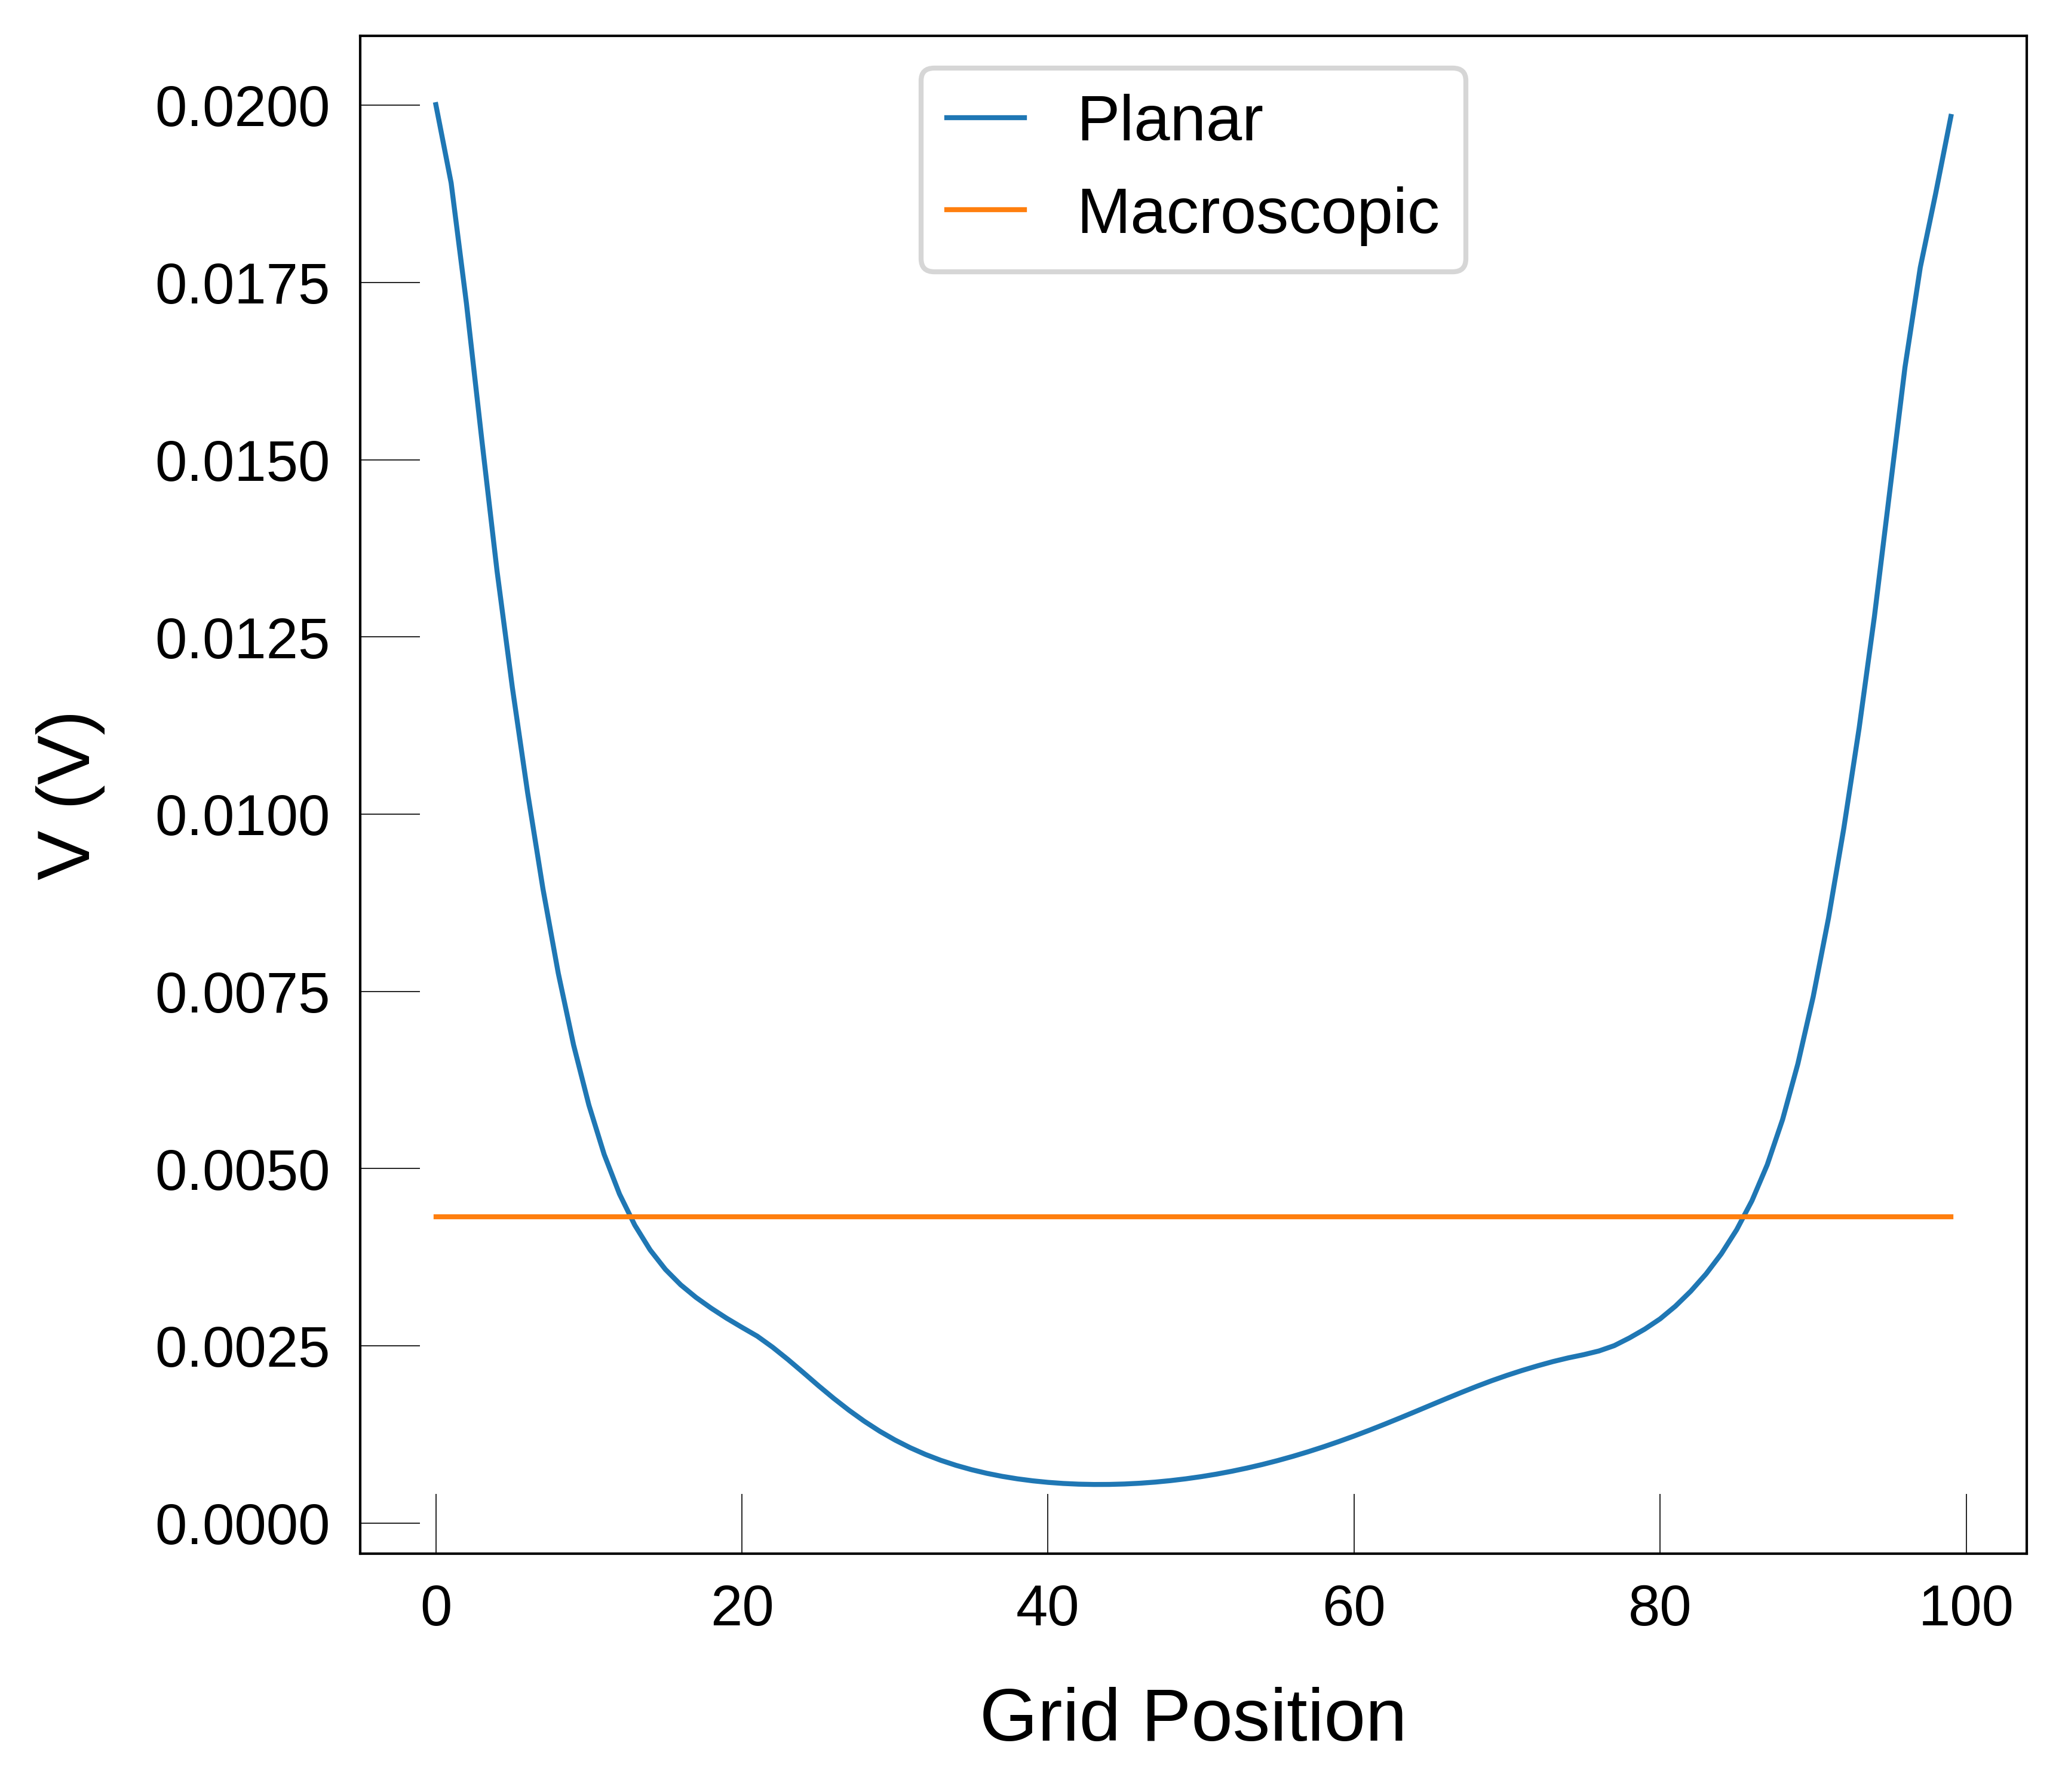

In [4]:
input_file = "cube_001_spin_density.cube"
lattice_vector = 4.75
output_file = 'PlanarCube.csv'
img_file = 'PlanarCube.png'

df, fig = md.plot_planar_average(
    lattice_vector=lattice_vector, 
    input_file=input_file, 
    output_file=output_file, 
    img_file=img_file
)

## Distinguishing plateau regions in the electrostatic potential
The code below aims to detect plateau regions in the electrostatic potential of a material. It takes inputs such as cube size, cube origin in fractional unit cell coordinates, a tolerance threshold for identifying plateaus, and an input `VASP LOCPOT` filename. The output is the percentage of cubes categorized as non-vacuum versus vacuum, providing insight into areas of consistent potential within the material.

### Getting potential values 

In [10]:
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot, NGX, NGY, NGZ)
cutoff_varience = tolerance
grad_x, grad_y, grad_z = np.gradient(grid_pot[:,:,:], resolution_x, resolution_y, resolution_z)
travelled = [0,0,0]

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


### Distinguishing between vaccuum and non-vaccuum cubes 

In [11]:
vacuum = []
non_vacuum = []
for i in range(0,NGX,cube_size[0]):
    for j in range(0,NGY,cube_size[1]):
        for k in range(0,NGZ,cube_size[2]):
            sub_origin = [float(i)/NGX,float(j)/NGY,float(k)/NGZ]
            cube_pot, cube_var = md.volume_average(origin=sub_origin,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ,travelled=[0,0,0])
            if cube_var <= cutoff_varience:
                vacuum.append(sub_origin)
            else:
                non_vacuum.append(sub_origin)
                
print("Number of vacuum cubes: ", len(vacuum))
print("Number of non-vacuum cubes: ", len(non_vacuum))
print("Percentage of vacuum cubes: ",(float(len(vacuum))/(float(len(vacuum))+float(len(non_vacuum)))*100.))
print("Percentage of non-vacuum cubes: ",(float(len(non_vacuum))/(float(len(vacuum))+float(len(non_vacuum)))*100.))

Number of vacuum cubes:  17
Number of non-vacuum cubes:  4079
Percentage of vacuum cubes:  0.4150390625
Percentage of non-vacuum cubes:  99.5849609375


## Aligning band edged to reference potentials
The code below deals with aligning band edges to the reference potential within interstitial regions of a material. Input parameters include the positions of interstitial spaces, the `VASP OUTCAR` and `LOCPOT` filenames, and the size of a cube defined by `LOCPOT` FFT mesh points. The function's output consists of the aligned valence band, aligned conduction band, and variances within the interstitial regions.

### Input Section

In [12]:
interstices = ([0.5,0.5,0.5], [0.25,0.25,0.25])
outcar = 'OUTCAR.test'
locpot = 'LOCPOT.test'
cube_size = [2,2,2]

### Getting potential values and band edges 

In [13]:
# GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(locpot, quiet=True)
vector_a, vector_b, vector_c, av, bv, cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot, NGX, NGY, NGZ)

# GETTING BAND EDGES
band_extrema = md.get_band_extrema(outcar)
VB_eigenvalue = band_extrema[0]
CB_eigenvalue = band_extrema[1]

Reading header information...
Reading 3D data using Pandas...


### Calculating reference states and the aligned band energies 

In [16]:
## CALCULATING REFERENCE STATE
interstitial_potentials = []
interstitial_variances = []
for interstice in interstices:
    locpot_extract = md.volume_average(
        origin=interstice,
        cube=cube_size,
        grid=grid_pot,
        nx=NGX,
        ny=NGY,
        nz=NGZ
    )
    interstitial_potentials.append(locpot_extract[0])
    interstitial_variances.append(locpot_extract[1])

## CALCULATING ALIGNED BAND ENERGIES
sum_interstitial_potential = 0
for ele in interstitial_potentials:
    sum_interstitial_potential += ele
average_interstitial_potential = sum_interstitial_potential/len(interstitial_potentials)
VB_aligned = round(VB_eigenvalue - average_interstitial_potential,2)
CB_aligned = round(CB_eigenvalue - average_interstitial_potential,2)

## PRINTING
print("Reading band edges from file: " + str(outcar))
print("Reading potential from file: " + str(locpot))
print("Interstital variances: " + str(interstitial_variances))
print("VB_aligned (eV)      CB_aligned (eV)")
print("--------------------------------")
print(VB_aligned, "             ", CB_aligned)


Reading band edges from file: OUTCAR.test
Reading potential from file: LOCPOT.test
Interstital variances: [1.8665165271901357e-05, 6.277207757909537e-06]
VB_aligned (eV)      CB_aligned (eV)
--------------------------------
-3.24               -1.72


## Potential variation along a specified vector

We can plot how the electrostatic potential varies along a vector using the function `macrodensity.plotting.plot_variation_along_vector`:
This variation is calculated by moving a cube along the vector and calculating the potential average for each individual cube. 
To use the function, we have to define the vector, the cube size, origin point, magnitude and input file. 
This will return a figure showing the averaged electrostatic potential along the vector.

![](./movingcube.gif)

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


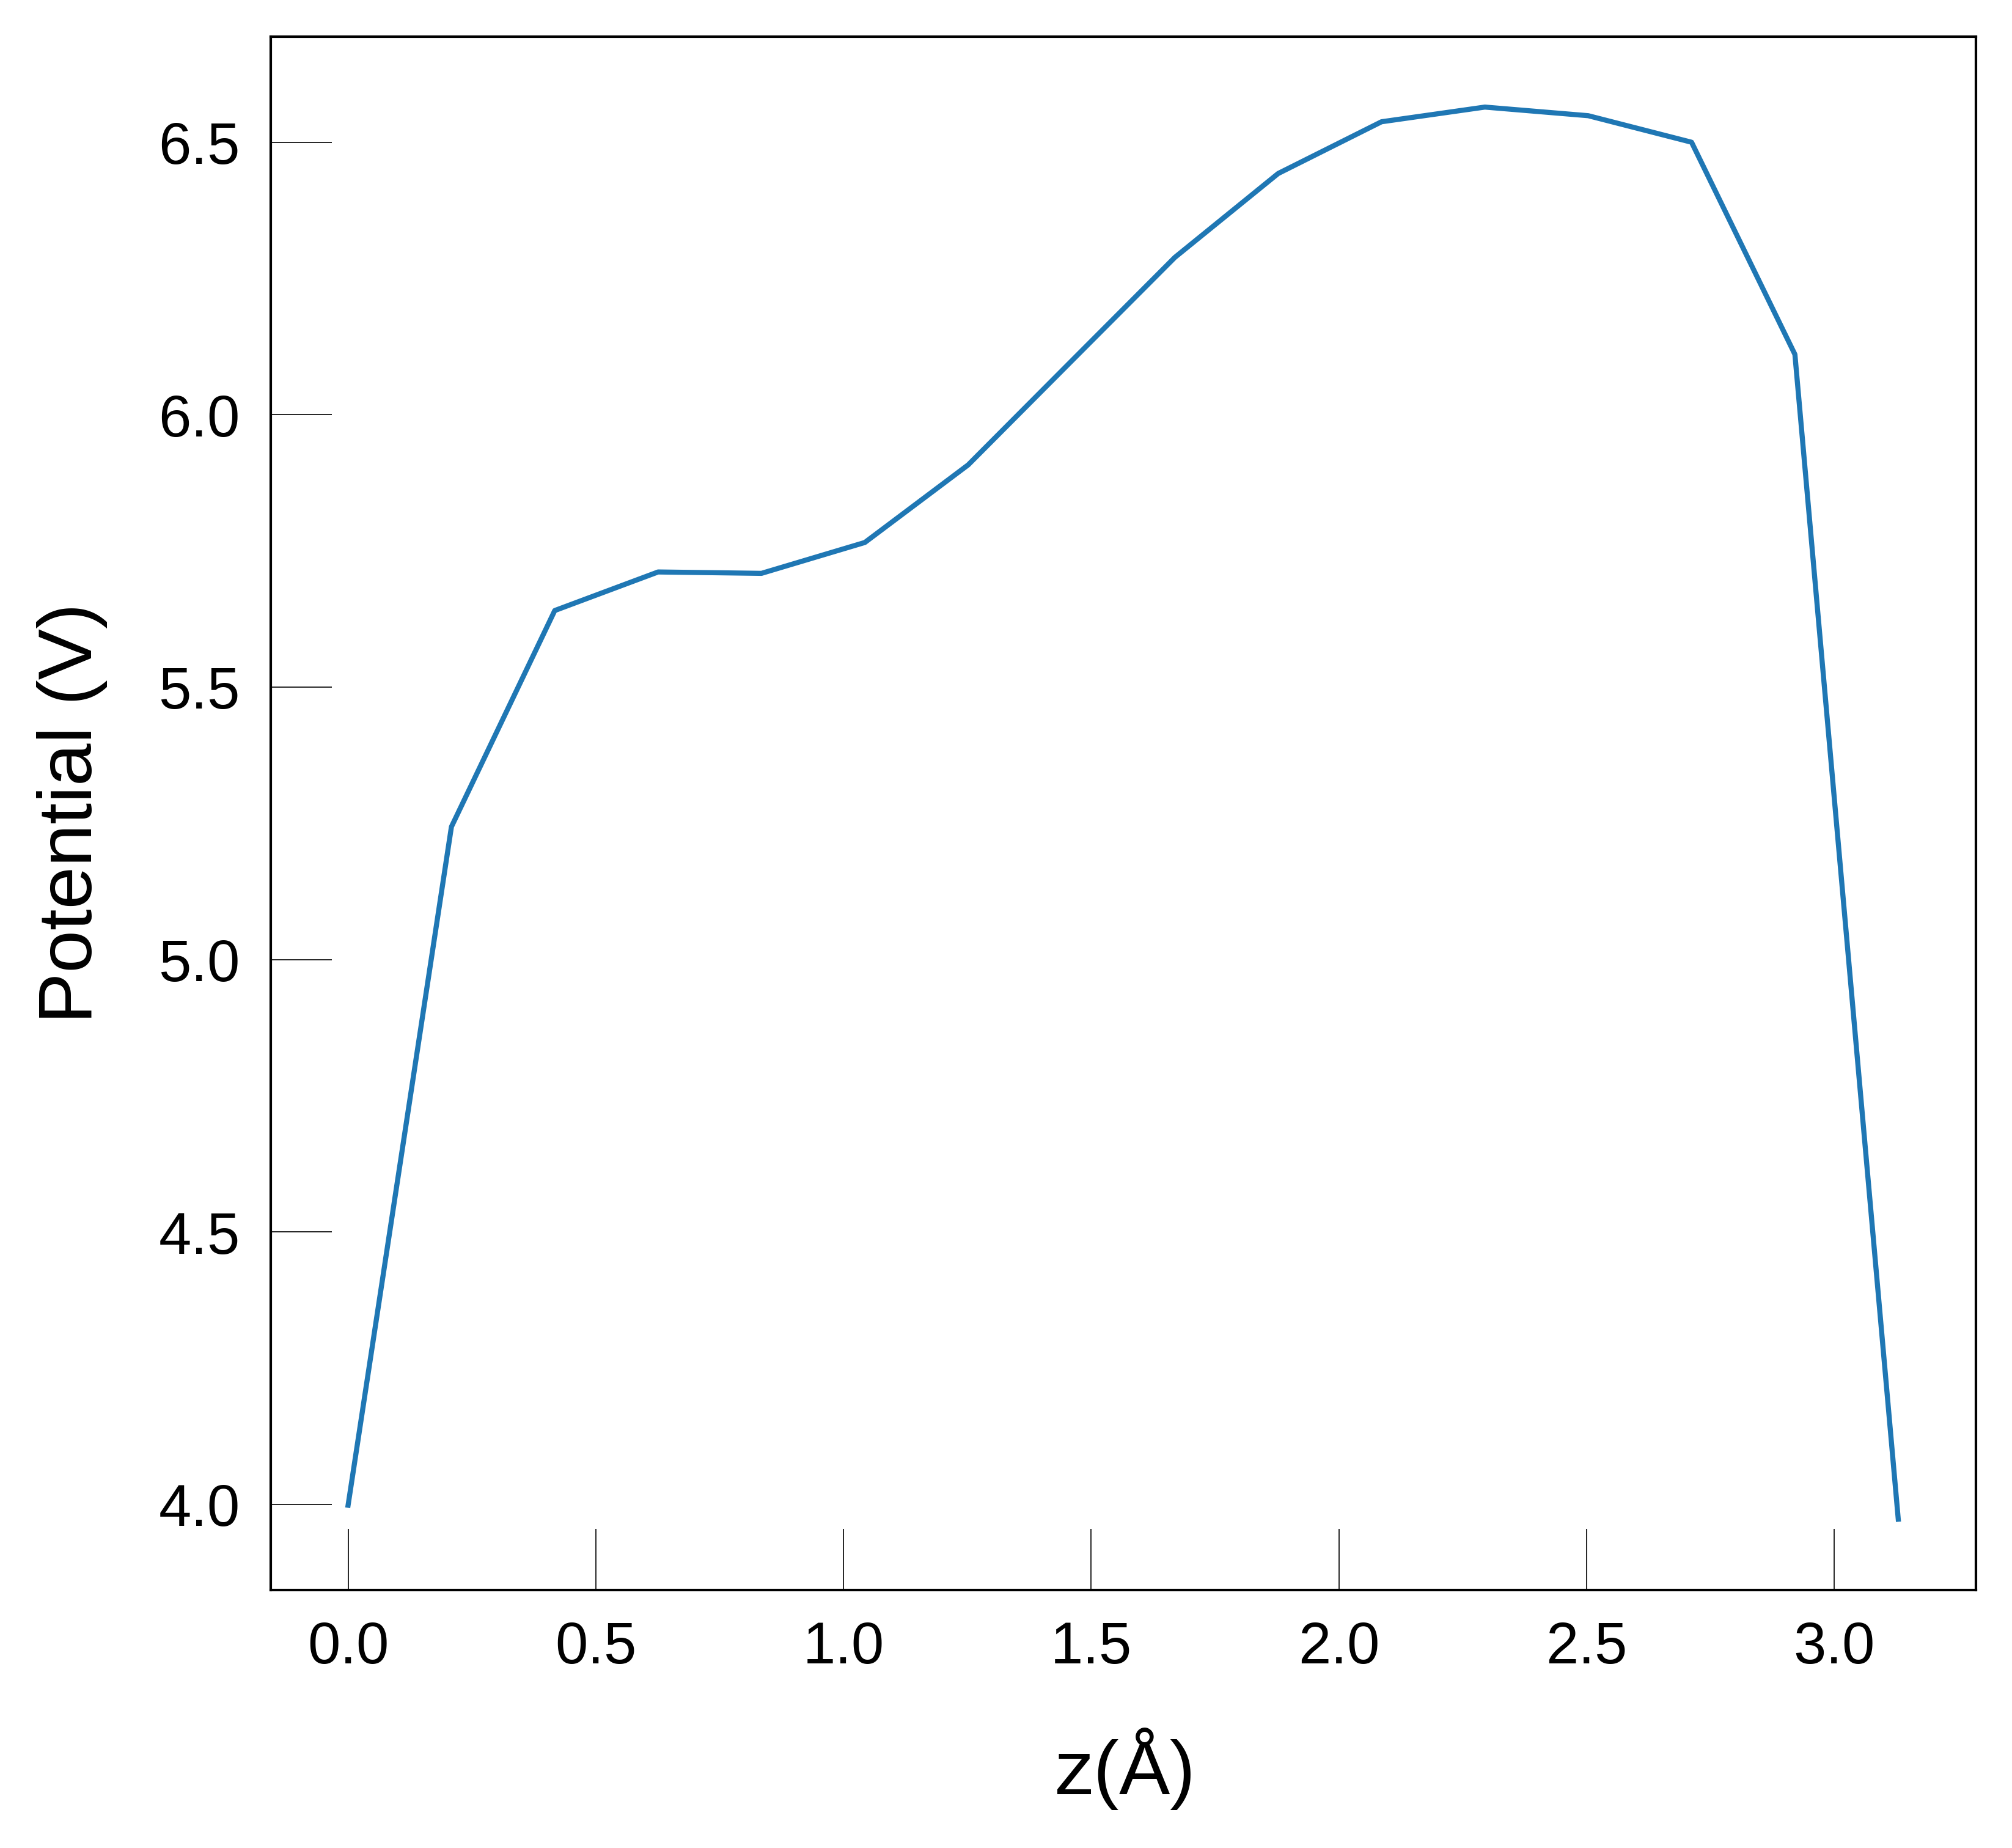

In [2]:
import macrodensity

vector = [1, 1, 1]
cube_size = [1, 1, 1]
origin_point = [0.17, 0.17, 0.17]
vector_magnitude = 16
input_file = 'LOCPOT.test'

fig = macrodensity.plotting.plot_variation_along_vector(
    cube_size=cube_size,
    origin_point=origin_point,
    vector=vector,
    vector_magnitude=vector_magnitude,
    input_file = 'LOCPOT.test',
    show_electric_field=False, # don't show variation of electric field
)

We can also show the variation of the electric field by setting `show_electric_field=True`:

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


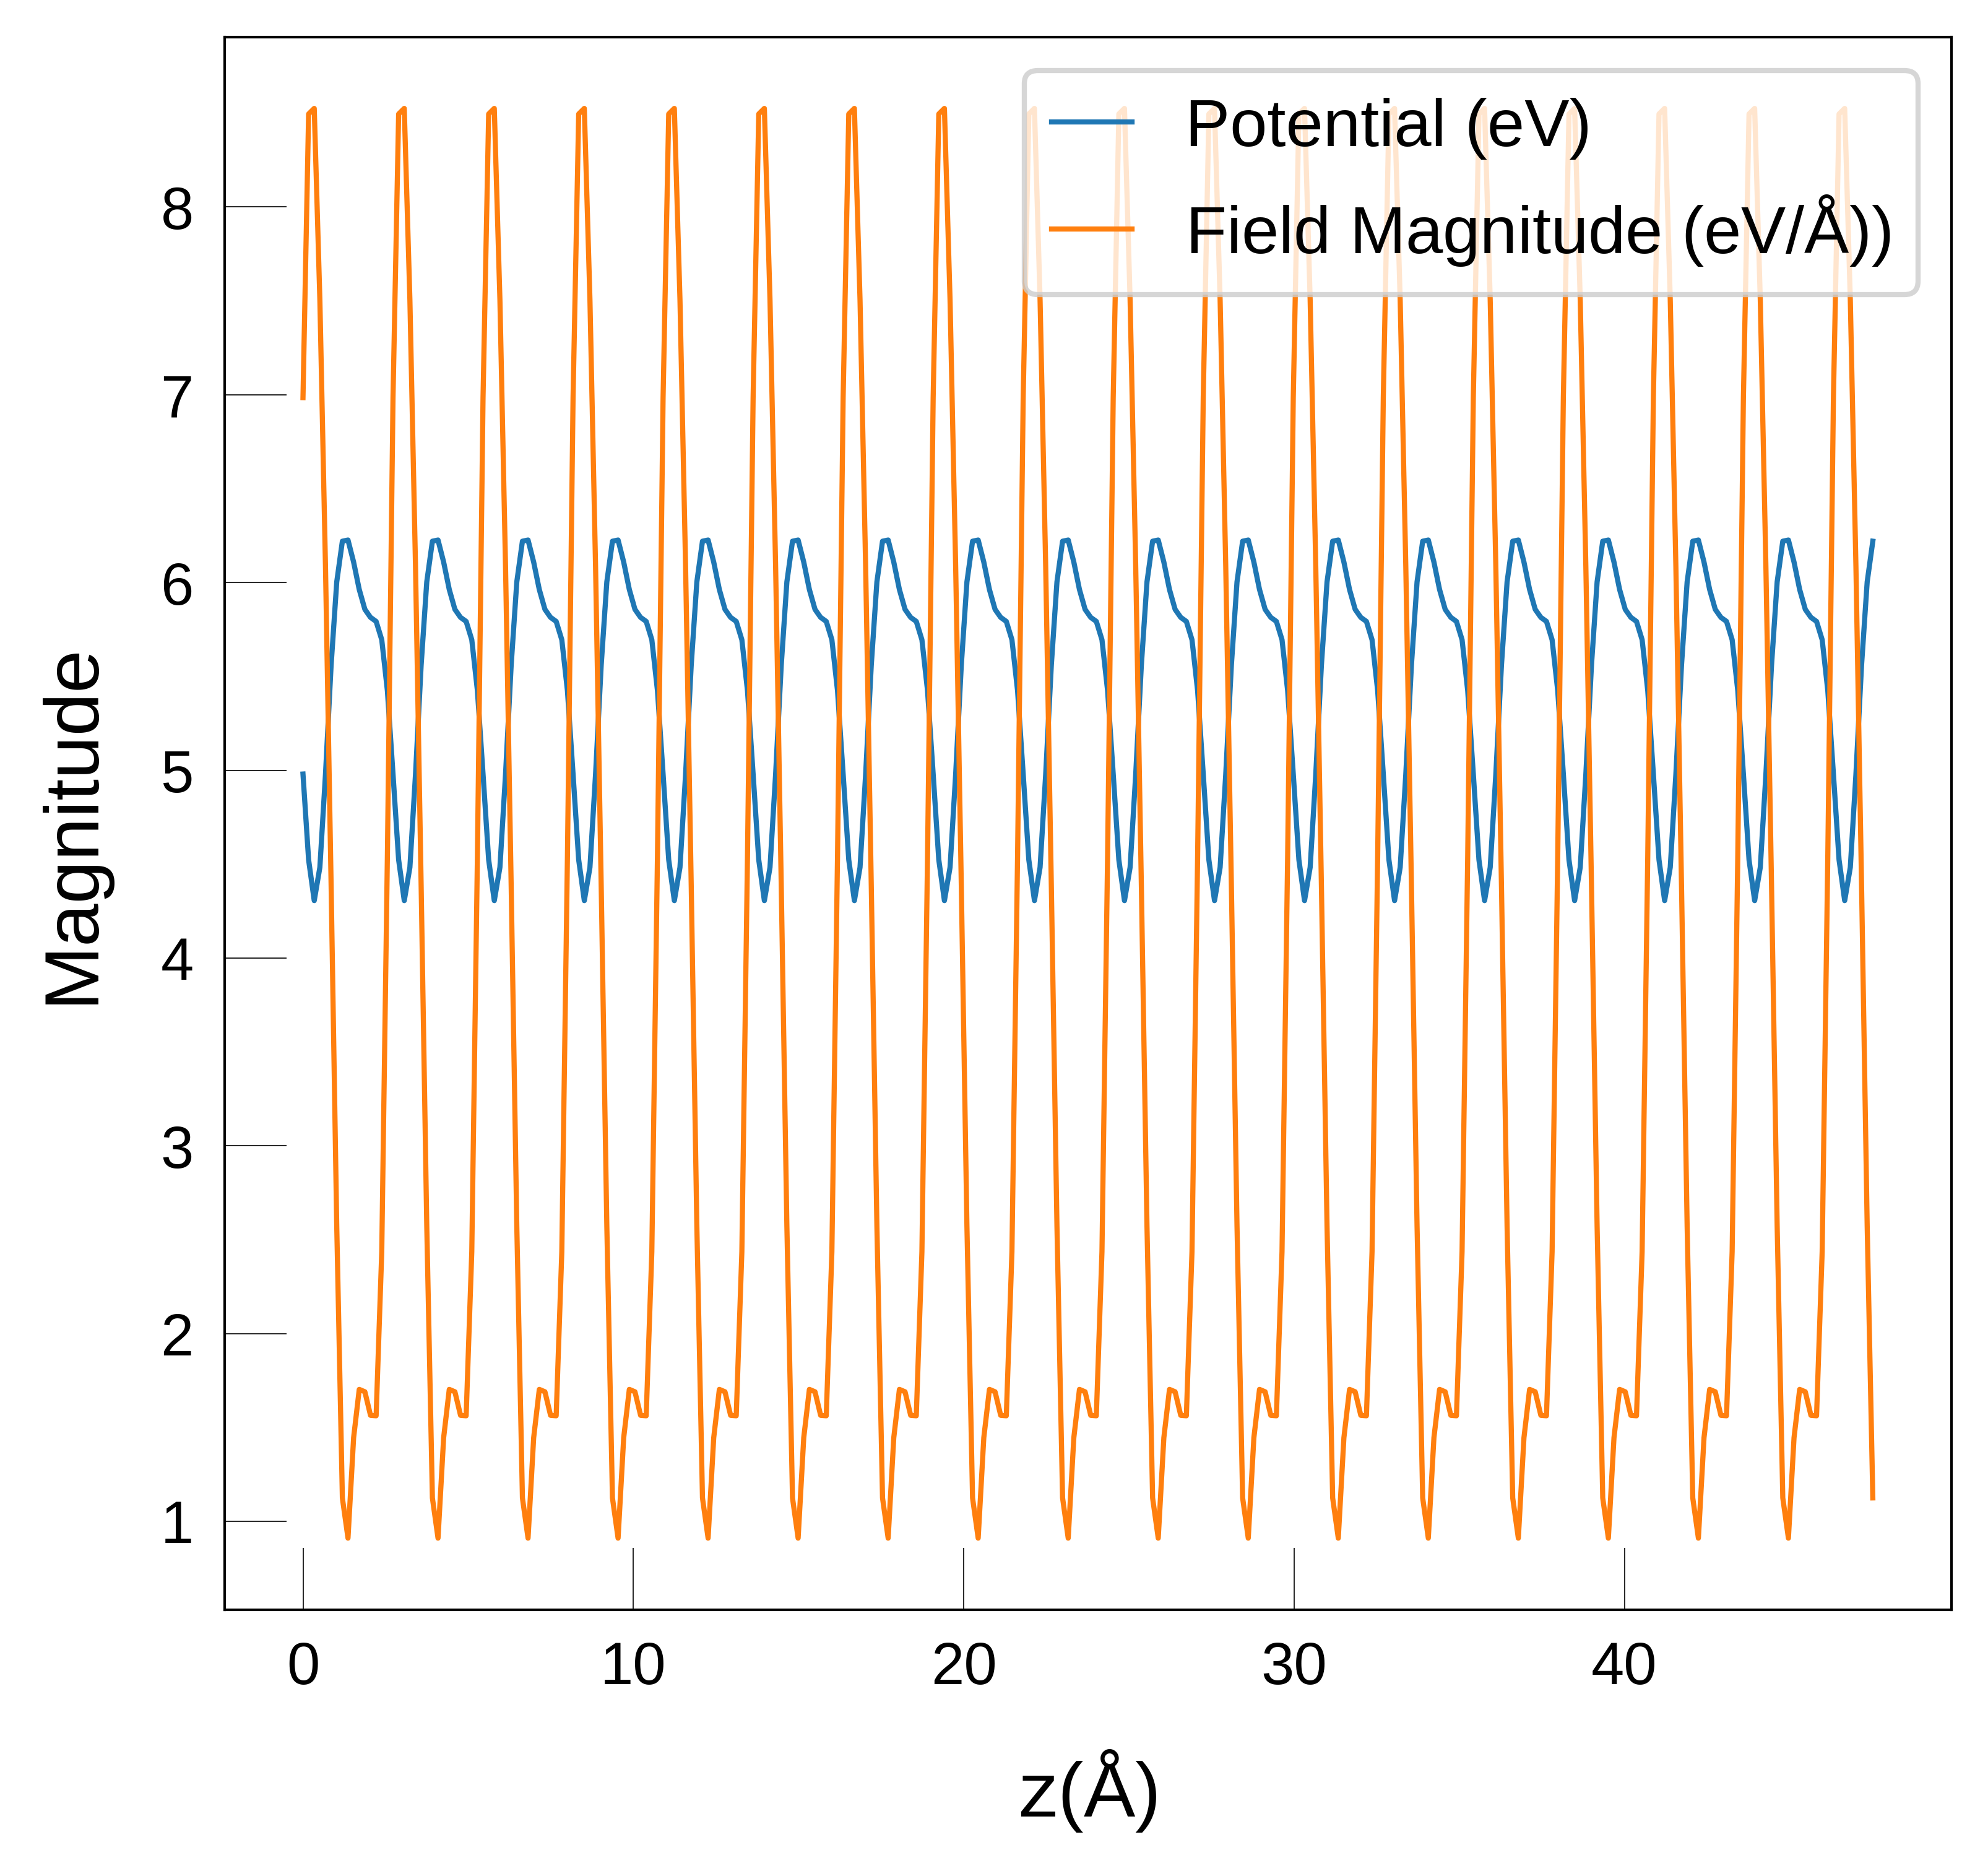

In [4]:
import macrodensity

input_file = 'LOCPOT.test'
cube_size = [2,2,2]
vector = [1,1,0]
origin_point = [0.5, 0, 0.5]
vector_magnitude = 280

fig = macrodensity.plot_variation_along_vector(
    input_file=input_file,
    cube_size=cube_size,
    vector=vector,
    origin_point=origin_point,
    vector_magnitude=vector_magnitude,
    show_electric_field=True
)

## Plotting the Onsite (Hartree) Potential 

We can plot the on-site electrostatic potential for a specific species using the function `macrodensity.plotting.plot_on_site_potential`:

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


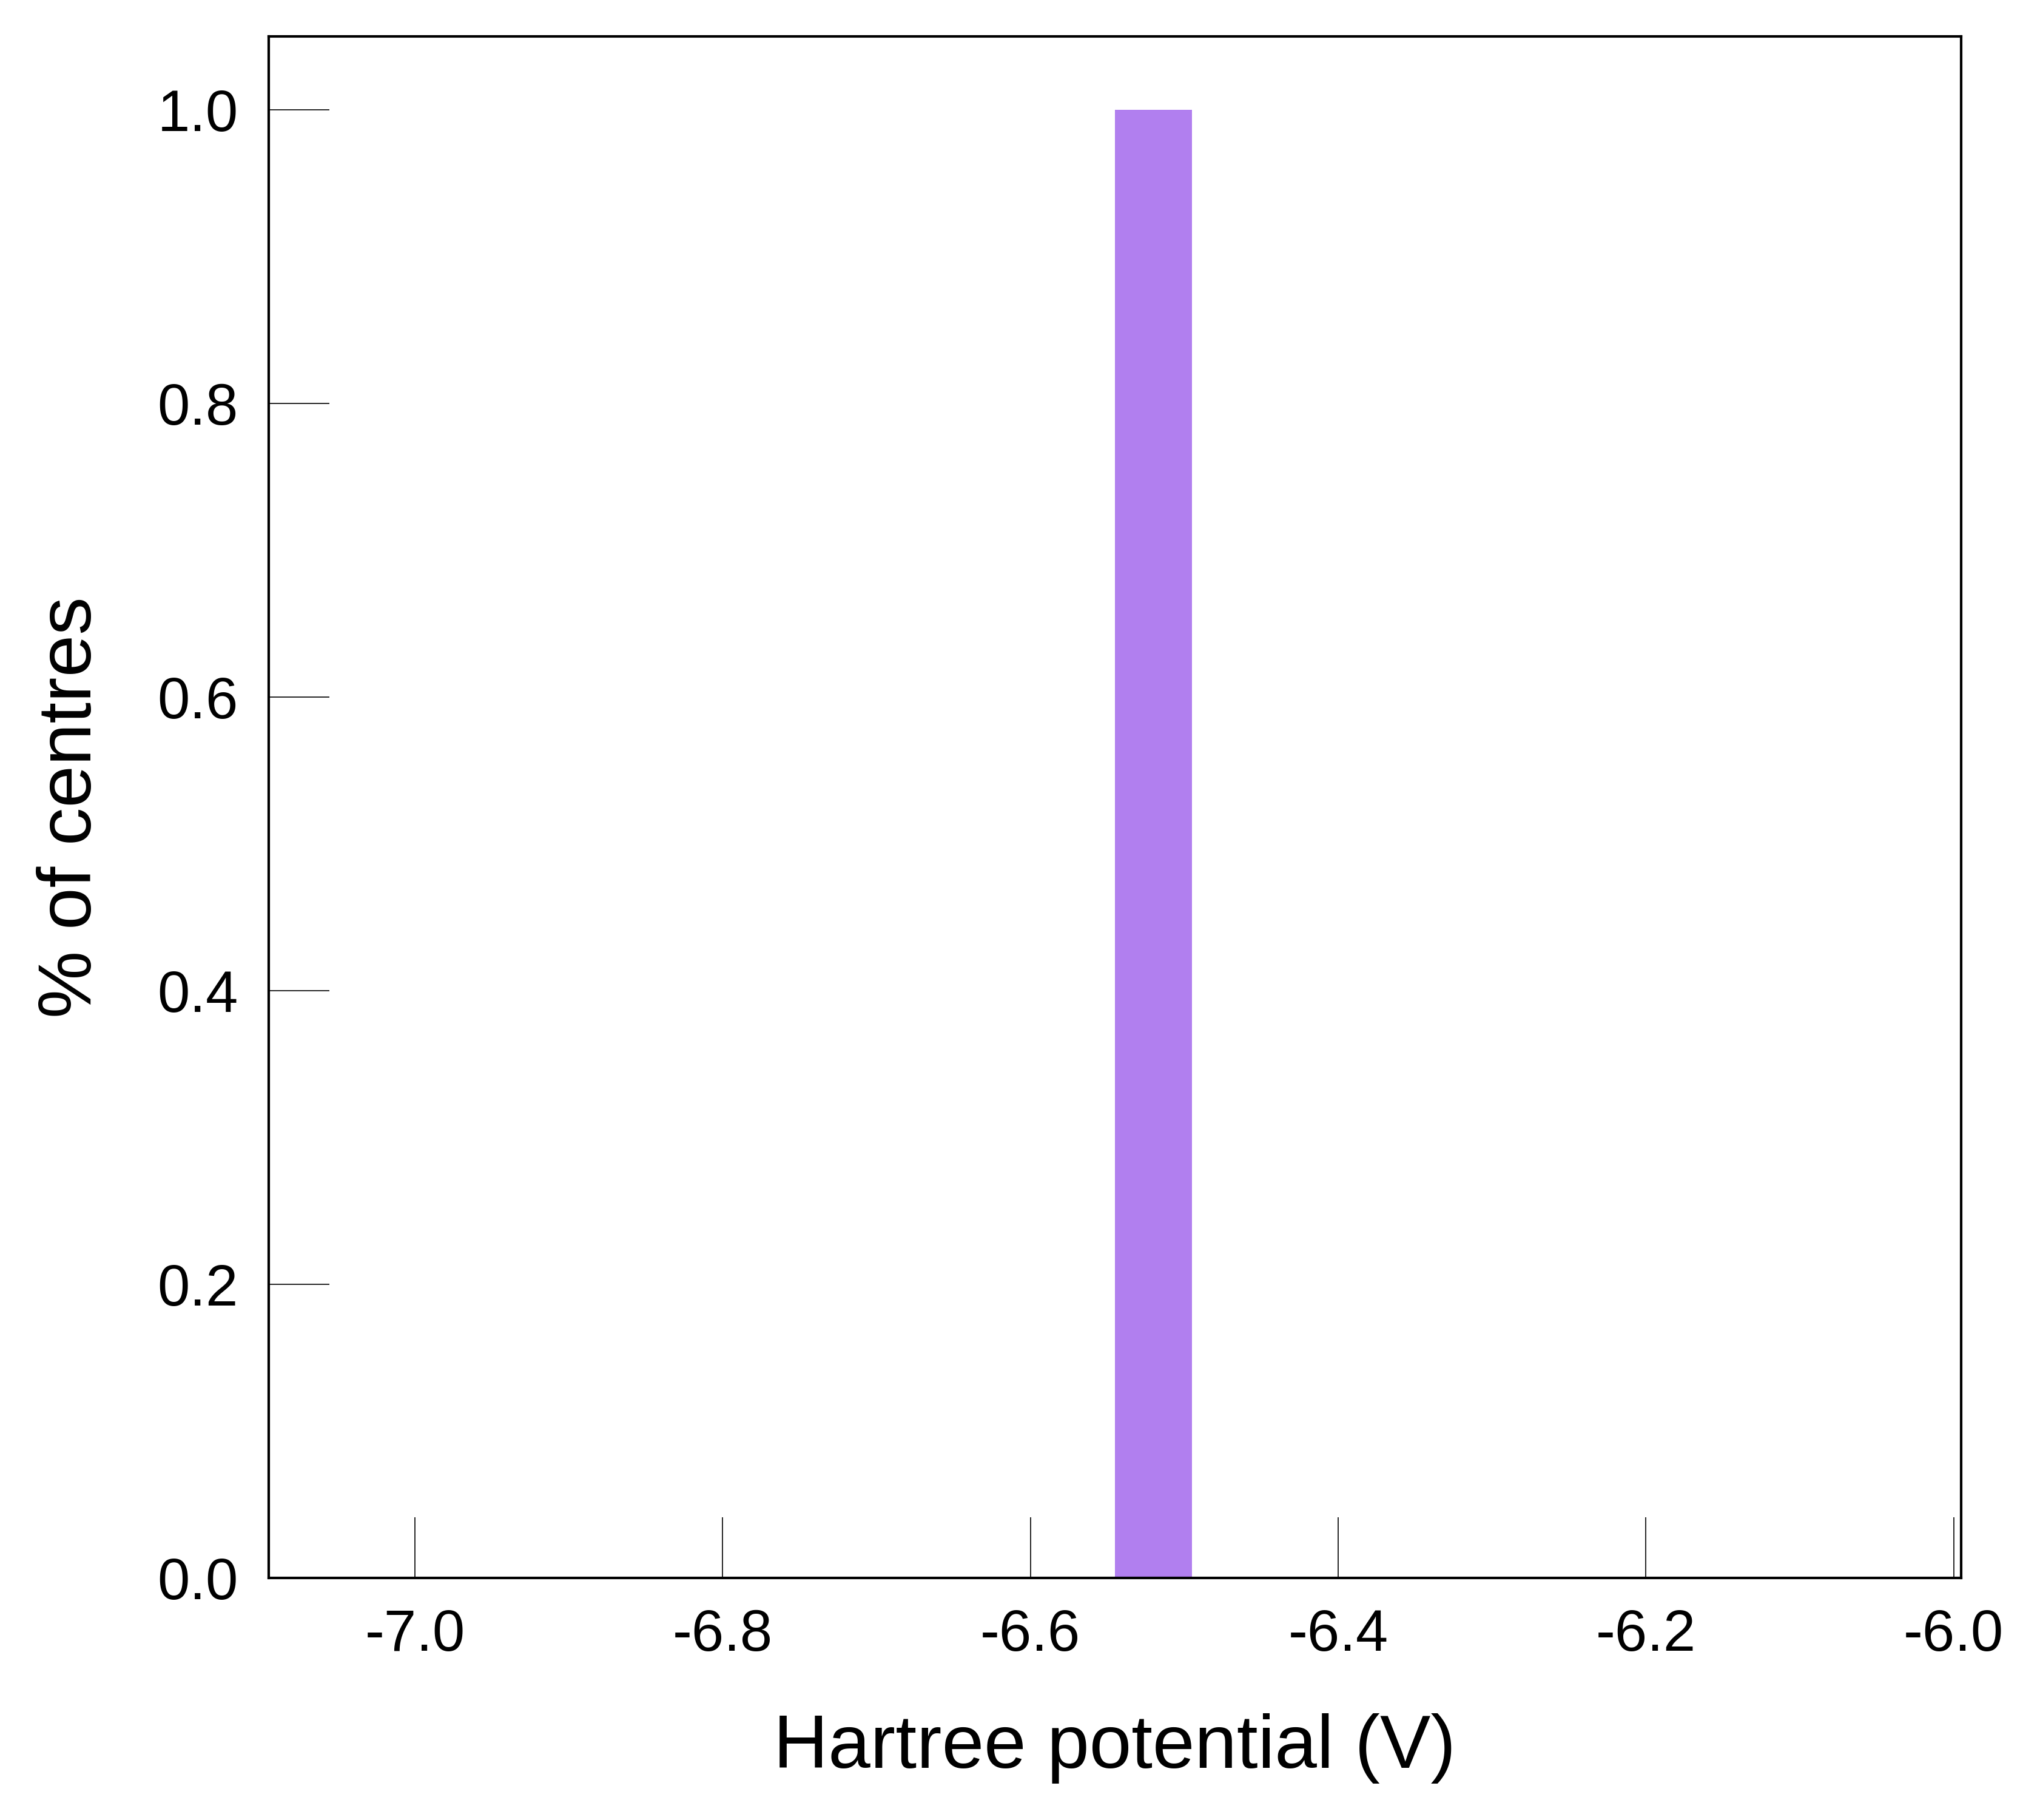

In [12]:
import macrodensity

## INPUT SECTION
potential_file = 'LOCPOT.test'
coordinate_file = 'POSCAR.test'
species = "Zn"
sample_cube = [5, 5, 5]

df, fig = macrodensity.plotting.plot_on_site_potential(
    species=species,
    potential_file=potential_file,
    coordinate_file=coordinate_file,
    sample_cube=sample_cube,
)

## Calculating the Spherical Average around a given point in a material

To analyse the distribution of the potential within defined spatial regions, we can calculate the spherical average of the potential around a given point by defining a cube around that point.

To do this, we define the cube size, origin point, and input file and feed them to the function `macrodensity.tools.spherical_average`. The output is the averaged potential distribution within the defined cube region.

In [10]:
from macrodensity.tools import spherical_average

cube_size = [2, 2, 2]
cube_origin = [0.5, 0.5, 0.5]
input_file = 'LOCPOT.test'

cube_pot, cube_var = spherical_average(
    cube_size=cube_size,
    cube_origin=cube_origin,
    input_file = 'LOCPOT.test'
)

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Potential            Variance
--------------------------------
6.5579496029375     1.8665165271901357e-05
